<a href="https://colab.research.google.com/github/Bowist27/MultiAgentes/blob/main/SegregationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mesa seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 12

In [23]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime


In [29]:
class SegregationAgent(Agent):

  def __init__(self, id, model, type, threshold):
    super().__init__(id, model)
    self.type = type
    self.threshold = threshold

  def step(self):
    neighbors = self.model.grid.get_neighbors(self.pos, moore = True, include_center = False)

    count = 0
    for agent in neighbors:
      if agent.type == self.type:
        count += 1

    percentage = 0
    if len(neighbors) != 0:
      percentage = count / len(neighbors)
    # Si es menor usamos el move to empty, mueve el agente a una celda vacia aleatoria
    if percentage < self.threshold:
      # Hacer el cambio al mismo agente
      self.model.grid.move_to_empty(self)


In [30]:
# Pondremos unos si esta vacio y haremos una numeracion para grid (1,2,3...)
def get_grid(model):
  grid = np.zeros( (model.grid.width, model.grid.height) )
  #Puede ser que la celda este vacia, entonces haremos una condicion
  for content, (x,y) in model.grid.coord_iter():
    if content != None:
      grid[x][y] = content.type
  return grid

# Si quisieramos sacar el valor promedio, tendriamos que recuperar el porcentaje con una variable de instancia y ver como cambia a lo largo del tiempo

In [44]:
class SegregationModel (Model):
  #Tener el porcentaje de la tolerancia que quiero, si quisiera que cada agente tenga su propio nivel de tolerancia el treshold tendria que ser al azar en el anterior, Treshold
  #El porcentaje de celdas vacias en un tercio
  def __init__(self, width, height, types=2, threshold=0.30, empty_cells=0.33):
    super().__init__()
    self.grid = SingleGrid(width, height, torus=False)
    self.schedule = RandomActivation(self)
    self.datacollector = DataCollector(
        model_reporters = {"Grid" : get_grid}
    )

    cells = int ((width * height) * (1 - empty_cells))
    amount_per_type = cells // types
    for i in range(types):
      for j in range(amount_per_type):
        agent = SegregationAgent((i,j), self, (i+1), threshold)
        self.grid.move_to_empty(agent)
        self.schedule.add(agent)

  def step (self):
    self.datacollector.collect(self)
    self.schedule.step()


In [45]:
N = 30
ITERATIONS = 100

EMPTY_CELLS = 0.20

#Con respecto a los agentes tendremos 2 tipos de agentes
TYPES = 2

THRESHOLD = 0.60

model = SegregationModel(N, N, TYPES, THRESHOLD, EMPTY_CELLS)
for i in range(ITERATIONS):
  model.step()

In [46]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head(5)

,Grid
0,"[[2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0,..."
1,"[[2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0,..."
2,"[[2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0,..."
3,"[[2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0,..."
4,"[[2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 2.0, 0.0,..."


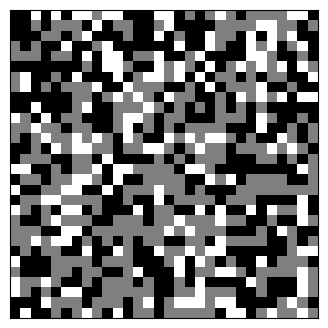

In [47]:
fig, axis = plt.subplots(figsize = (4, 4))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grids.iloc[i,0])

anim = animation.FuncAnimation(fig, animate, frames=ITERATIONS)
anim
